In [47]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [48]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-09ca2822-5d65-19b0-5b78-ac3c7d3489e2)


In [49]:
import os
os.chdir("/content/gdrive/MyDrive/lxmert")

# Classifier for Answer Types

In [ ]:
import json
with open('data/vqa/classifier_ans2label.json') as f_a2l:
  ans2label = json.load(f_a2l)

In [ ]:
!pip install transformers

BERT + BiLSTM classifier

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import Tensor
import torch.nn.functional as F
from transformers import AutoModel, BertTokenizerFast, BertTokenizer, AutoTokenizer, BertModel, BertForSequenceClassification
import numpy as np
from tqdm import tqdm

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self,embedding_dim, hidden_dim, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=embedding_dim,
                    hidden_size=hidden_dim,
                    num_layers=num_layers,
                    batch_first=False,
                    bidirectional=True)
        self.fc1 = torch.nn.Linear(2*hidden_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
    
    
    def forward(self, embeddings):
        self.lstm.flatten_parameters()
        lstm_output, _ = self.lstm(embeddings)
        output = lstm_output[:,-1,:]
        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)
        return output

class BertBiLSTM(nn.Module):
    def __init__(self, num_layers, num_classes, embedding_dim=768, hidden_dim=128):
        super(BertBiLSTM, self).__init__()
        
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        self.classifier = BiLSTM(self.embedding_dim, hidden_dim, num_layers, num_classes)
       
    def forward(self, input_ids, attention_mask):
        text_embeddings = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_embeddings = text_embeddings[0]
        
        output = self.classifier(text_embeddings)
        return output

Get DataLoader, Preprocessing

In [ ]:
MAX_LEN = 64

def preprocessing_for_bert(tokenizer, sentences):
    input_ids = []
    attention_masks = []
    num_sentences = len(sentences)

    for i, sent in enumerate(sentences):
      encoded_sent = tokenizer.encode_plus(text=sent, 
                          add_special_tokens=True,        
                          max_length=MAX_LEN,               
                          padding='max_length',         
                          return_attention_mask=True, 
                          truncation=True)     
      input_ids.append(encoded_sent.get('input_ids'))
      attention_masks.append(encoded_sent.get('attention_mask'))

    return input_ids, attention_masks


In [ ]:
def get_data(filename, tokenizer, save_location):
    all_input_ids, all_attn_masks = [], []
    data, labels = [], [] 
  
    with open(filename, 'r') as df:
      df = df.read()
      df = json.loads(df)
      for i in range(len(df)):
        data.append(df[i]['sent'])
        labels.append(ans2label[df[i]['question_type']])
        
    input_ids, attention_masks = preprocessing_for_bert(tokenizer, data)
    all_input_ids.append(input_ids)
    all_attn_masks.append(attention_masks)
    np.savez(save_location, input_ids=all_input_ids, attention_masks=all_attn_masks, labels=labels)


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Store tokenized data

In [ ]:
get_data("data/vqa/train.json", tokenizer, "data/vqa/train_bert_tokenized.npz")

In [ ]:
get_data("data/vqa/valid.json", tokenizer, "data/vqa/val_bert_tokenized.npz")

In [ ]:
def load_dataset(location):
    data = dict(np.load(location))
    for key, elem in data.items():
        data[key] = torch.tensor(elem)
    dataset = TensorDataset(data['input_ids'].squeeze(), data['attention_masks'].squeeze(), data['labels'])
    return dataset 

In [ ]:
train_path = "data/vqa/train_bert_tokenized.npz"
train_dataset = load_dataset(train_path)

In [ ]:
test_path = "data/vqa/val_bert_tokenized.npz"
test_dataset = load_dataset(test_path)

Train and Evaluate functions

In [ ]:
def evaluate(network, loader, loss_fn, data_size):
    loss = 0.0
    acc = 0.0
    with torch.no_grad():
      for i, (input_ids, masks, labels) in tqdm(enumerate(loader),total=len(loader),position=0, leave=True):
          input_ids = input_ids.cuda()
          masks = masks.cuda()
          labels = labels.cuda()
            
          output = network(input_ids, masks)
          loss += loss_fn(output,labels)
          preds = torch.argmax(output,dim=1)
          #output = network(input_ids, masks, labels=labels)
          #preds = torch.argmax(output.logits, dim=1)
          #loss = output.loss

          acc += torch.eq(preds, labels).sum().item()
    return loss.item() / data_size, acc / data_size
    #return loss.item() / len(loader), acc / data_size

In [ ]:
def train(directory, network, loss_fn, train_dataset, test_dataset, optimizer, scheduler, batch_size, num_epochs, verbose=True, val_freq=5):
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
    
    train_loss, train_acc = torch.zeros(num_epochs), torch.zeros(num_epochs)
    test_loss, test_acc = torch.zeros(num_epochs//val_freq + 1), torch.zeros(num_epochs//val_freq + 1)
    val_best_acc, train_best_acc = 0.0, 0.0
    os.makedirs(directory, exist_ok=True)
    for epoch in range(num_epochs):
        if epoch % val_freq == 0:
          network.eval()
          idx = epoch//val_freq
          test_loss[idx], test_acc[idx] = evaluate(network, val_dataloader, loss_fn, len(test_dataset))
          if test_acc[idx] > val_best_acc:
            val_best_acc = test_acc[idx]
            torch.save(network.state_dict(), f"{directory}/snapshot_val_best")
          if verbose:
            print(f"epoch:{epoch:3d}, test_loss: {test_loss[idx]:3.6f}, test_acc: {test_acc[idx]:3.5f}")

        network.train()
        train_epoch_loss, train_epoch_acc = 0.0, 0.0
        for i, (input_ids, masks, labels) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), position=0, leave=True):
            input_ids = input_ids.cuda()
            masks = masks.cuda()
            labels = labels.cuda()              
            optimizer.zero_grad() 
            
            output = network(input_ids, masks)
            pred = torch.argmax(output, dim=1)
            train_epoch_acc += torch.eq(pred, labels).sum().item()
            loss = loss_fn(output,labels)/batch_size

            # commented lines are codes for BertSeqeucen
            #output = network(input_ids, masks, labels=labels)       
            #pred = torch.argmax(output.logits, dim=1)
            #loss = output.loss
            train_epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_acc[epoch] = train_epoch_acc / len(train_dataset)
        train_loss[epoch] = train_epoch_loss / len(train_dataloader)
        print(f"train_loss:{train_loss[epoch]:.6f}, train_acc:{train_acc[epoch]:.6f}")
        if (train_acc[epoch] > train_best_acc):
          train_best_acc = train_acc[epoch]
          torch.save(network.state_dict(), f"{directory}/snapshot_train_best")

        scheduler.step(test_acc[epoch//val_freq])

    network.eval()   
    test_loss[-1], test_acc[-1] = evaluate(network, val_dataloader, loss_fn, len(test_dataset))    
    torch.save(train_loss, f"{directory}/train_loss")
    torch.save(test_loss, f"{directory}/test_loss")
    torch.save(train_acc, f"{directory}/train_acc")
    torch.save(test_acc, f"{directory}/test_acc")
    torch.save(network.state_dict(), f"{directory}/snapshot_final")


Dir for storing checkpoints

In [ ]:
def get_path(loss, opt, lr, batch_size, epoch):
    return f"{PATH}/lr_{lr}_bs_{batch_size}_loss_{loss}_epoch_{epoch}_opt_{opt}"

Train Bert + BiLSTM

In [ ]:
loss = 'ce'
opt = 'adam'
batch_size = 32
lr = 1e-5
num_epochs = 50

In [ ]:
PATH = "bert_bilstm_classifier"
directory = f"{get_path(loss, opt, lr, batch_size, num_epochs)}"
os.makedirs(directory, exist_ok=True)

torch.manual_seed(11777)
num_layers, num_classes = 2, len(list(ans2label.keys()))#

In [ ]:
network = BertBiLSTM(num_layers, num_classes)
network = network.cuda()

In [ ]:
optimizer = optim.Adam(network.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=2, verbose=True, mode='max')

Trained with Bert Param Freezed

In [ ]:
train(directory, network, loss_fn, train_dataset, test_dataset, optimizer, scheduler, batch_size, num_epochs)

In [ ]:
test_acc = torch.load(f"{directory}/test_acc")
print(test_acc)
train_acc = torch.load(f"{directory}/train_acc")
print(train_acc)

135 Freezed + 5 Unfreezed (no improvement)

In [ ]:
network = BertBiLSTM(num_layers, num_classes)
network.load_state_dict(torch.load(f"{directory}/snapshot_final_epoch_135"))
network.cuda()

In [ ]:
# Now we UNFREEZE Bert Param
train(directory, network, loss_fn, train_dataset, test_dataset, optimizer, scheduler, batch_size, 20)

Train with unfreezed bert from the start

In [ ]:
train(directory, network, loss_fn, train_dataset, test_dataset, optimizer, scheduler, batch_size, num_epochs)

Try using bert Sequence Classifier

In [ ]:
from transformers import BertForSequenceClassification

In [ ]:
network2 = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                              num_labels=len(list(ans2label.keys())),
                              output_attentions=True,
                              output_hidden_states=True)             

In [ ]:
loss = 'ce'
opt = 'adam'
batch_size = 32
lr = 1e-5
num_epochs = 135
PATH = "bert_sequence_classifier"
directory = f"{get_path(dataset, loss, opt, lr, batch_size)}"
os.makedirs(directory, exist_ok=True)

torch.manual_seed(11777)
optimizer = optim.Adam(network2.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=2, verbose=True, mode='max')

In [ ]:
network2.cuda()

In [ ]:
train(directory, network2, loss_fn, train_dataset, test_dataset, optimizer, scheduler, batch_size, num_epochs)

# Check Stored Classifier


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 4.3MB/s 
     |████████████████████████████████| 901kB 49.1MB/s 
     |████████████████████████████████| 3.3MB 48.9MB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import Tensor
import torch.nn.functional as F
from transformers import AutoModel, BertTokenizerFast, BertTokenizer, AutoTokenizer, BertModel
import numpy as np
from tqdm import tqdm

In [ ]:
CLASSIFIER_PATH = "/content/gdrive/MyDrive/lxmert/bert_bilstm_classifier/lr_1e-05_bs_32_loss_ce_epoch_50_opt_adam/snapshot_val_best"

bert_bilstm_classifier/lr_1e-05_bs_32_loss_ce_epoch_50_opt_adam


In [ ]:
def load_dataset(location):
    data = dict(np.load(location))
    for key, elem in data.items():
        data[key] = torch.tensor(elem)
    dataset = TensorDataset(data['input_ids'].squeeze(), data['attention_masks'].squeeze(), data['labels'])
    return dataset 
test_path = "data/vqa/val_bert_tokenized.npz"
test_dataset = load_dataset(test_path)

In [ ]:
classifier = BertBiLSTM(num_layers, num_classes)
classifier.load_state_dict(torch.load(CLASSIFIER_PATH)
classifier.cuda()

In [ ]:
val_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
classifier.eval()
loss_fn = nn.CrossEntropyLoss()
loss, acc = evaluate(classifier, val_dataloader, loss_fn, len(test_dataset))
print(loss, acc)

100%|██████████| 135/135 [00:05<00:00, 23.80it/s]

0.029047691096142227 0.634637647603612


# Combine with Main QA model

In [ ]:
!pip install -r requirements.txt

In [5]:
!pwd

/content/gdrive/.shortcut-targets-by-id/1XQxxii5VRN3kehCSLx8F8y2nADjT1S4d/lxmert


# alpha, beta both 1, BERT last layer, no scheduler


In [ ]:
!bash run/vqa_finetune.bash 0 vizwiz_bert_fuse_last_alpha_1_5 --alpha 1.5

2021-05-13 15:16:11.003614: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
train
Load 20523 data from split(s) train.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_train.pkl
Loaded 23948 images in file data/vizwiz_imgfeat/36_vizwiz_train.pkl in 98 seconds.
Use 20518 data in torch dataset
valid
Load 4319 data from split(s) valid.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_val.pkl
Loaded 7748 images in file data/vizwiz_imgfeat/36_vizwiz_val.pkl in 31 seconds.
Use 4317 data in torch dataset
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Downloading: 100% 232k/232k [00:00<00:00, 721kB/s]
Downloading: 100% 28.0/28.0 [00:00<00:00, 28.2kB/s]
Downloading: 100% 466k/466k [00:00<00:00, 1.16MB/s]
Downloading: 100% 570/570 [00:00<00:00, 539kB/s]
Downloading: 100% 440M/440M [00:09<00:00, 46.2MB/s]
Some weights of the model checkpoint at bert-base-uncas

In [ ]:
!bash run/vqa_finetune.bash 0 vizwiz_bert_fuse_last_alpha_0_5 --alpha 0.5

2021-05-13 23:11:15.755461: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
train
Load 20523 data from split(s) train.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_train.pkl
Loaded 23948 images in file data/vizwiz_imgfeat/36_vizwiz_train.pkl in 121 seconds.
Use 20518 data in torch dataset
valid
Load 4319 data from split(s) valid.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_val.pkl
Loaded 7748 images in file data/vizwiz_imgfeat/36_vizwiz_val.pkl in 36 seconds.
Use 4317 data in torch dataset
100% 231508/231508 [00:00<00:00, 323411.41B/s]
100% 407873900/407873900 [00:28<00:00, 14092196.21B/s]
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Downloading: 100% 232k/232k [00:00<00:00, 326kB/s]
Downloading: 100% 28.0/28.0 [00:00<00:00, 28.7kB/s]
Downloading: 100% 466k/466k [00:00<00:00, 526kB/s]
Downloading: 100% 570/570 [00:00<00:00, 545kB/s]
Downl

In [ ]:
!bash run/vqa_finetune.bash 0 vizwiz_bert_fuse_last_alpha_0_2_beta_0_8 --alpha 0.2 --beta 0.8 --epochs 20

2021-05-14 01:16:59.761299: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
train
Load 20523 data from split(s) train.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_train.pkl
Loaded 23948 images in file data/vizwiz_imgfeat/36_vizwiz_train.pkl in 98 seconds.
Use 20518 data in torch dataset
valid
Load 4319 data from split(s) valid.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_val.pkl
Loaded 7748 images in file data/vizwiz_imgfeat/36_vizwiz_val.pkl in 31 seconds.
Use 4317 data in torch dataset
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relatio

In [ ]:
!bash run/vqa_finetune.bash 0 vizwiz_bert_fuse_last_alpha_0_6_beta_0_4 --alpha 0.6 --beta 0.4 --epochs 20

2021-05-14 03:21:57.734944: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
train
Load 20523 data from split(s) train.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_train_tiny.pkl
Loaded 2000 images in file data/vizwiz_imgfeat/36_vizwiz_train_tiny.pkl in 11 seconds.
Use 1708 data in torch dataset
valid
Load 4319 data from split(s) valid.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_val_tiny.pkl
Loaded 500 images in file data/vizwiz_imgfeat/36_vizwiz_val_tiny.pkl in 7 seconds.
Use 283 data in torch dataset
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictio

# LXMERT joint with sheduler

In [ ]:
!bash run/vqa_finetune.bash 0 vizwiz_lxmert_joint_schduler --epochs 50

2021-05-13 13:31:32.263024: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
train
Load 20523 data from split(s) train.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_train.pkl
Loaded 23948 images in file data/vizwiz_imgfeat/36_vizwiz_train.pkl in 98 seconds.
Use 20518 data in torch dataset
valid
Load 4319 data from split(s) valid.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_val.pkl
Loaded 7748 images in file data/vizwiz_imgfeat/36_vizwiz_val.pkl in 31 seconds.
Use 4317 data in torch dataset
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load QA pre-trained LXMERT from snap/pretrained/model 
Loaded 2858 answers from LXRTQA pre-training and 45872 not

BertAdam Total Iters: 32050
Splits in Train data: ['train']
Splits in Valid data: ['valid']
0
1
2
3
4
Valid Oracle: 92.71
  0% 0/641 [00:00<?, ?it/s]/content/gdrive/.shortcut-targets-by-id/1XQxxii

In [9]:
!bash run/vqa_finetune.bash 0 vizwiz_lxmert_joint_schduler_a_4_b_6 --epochs 20 --alpha 0.4 --beta 0.6

2021-05-14 08:01:38.955852: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
train
Load 20523 data from split(s) train.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_train.pkl
Loaded 23948 images in file data/vizwiz_imgfeat/36_vizwiz_train.pkl in 98 seconds.
Use 20518 data in torch dataset
valid
Load 4319 data from split(s) valid.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_val.pkl
Loaded 7748 images in file data/vizwiz_imgfeat/36_vizwiz_val.pkl in 10 seconds.
Use 4317 data in torch dataset
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load QA pre-trained LXMERT from snap/pretrained/model 
Loaded 2858 answers from LXRTQA pre-training and 45872 not

BertAdam Total Iters: 12820
Splits in Train data: ['train']
Splits in Valid data: ['valid']
0
1
2
3
4
Valid Oracle: 92.71
  0% 0/641 [00:00<?, ?it/s]/content/gdrive/.shortcut-targets-by-id/1XQxxii

In [10]:
!bash run/vqa_finetune.bash 0 vizwiz_lxmert_joint_schduler_a_7_b_12 --epochs 20 --alpha -0.7 --beta 1.2

2021-05-14 09:18:17.533694: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
train
Load 20523 data from split(s) train.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_train.pkl
Loaded 23948 images in file data/vizwiz_imgfeat/36_vizwiz_train.pkl in 98 seconds.
Use 20518 data in torch dataset
valid
Load 4319 data from split(s) valid.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_val.pkl
Loaded 7748 images in file data/vizwiz_imgfeat/36_vizwiz_val.pkl in 31 seconds.
Use 4317 data in torch dataset
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load QA pre-trained LXMERT from snap/pretrained/model 
Loaded 2858 answers from LXRTQA pre-training and 45872 not

BertAdam Total Iters: 12820
Splits in Train data: ['train']
Splits in Valid data: ['valid']
0
1
2
3
4
Valid Oracle: 92.71
  0% 0/641 [00:00<?, ?it/s]/content/gdrive/.shortcut-targets-by-id/1XQxxii

# Fuse before cross-modality encoder

In [5]:
!bash run/vqa_finetune_v3.bash 0 vizwiz_early_bert

2021-05-14 12:05:36.254045: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
train
Load 20523 data from split(s) train.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_train.pkl
Loaded 23948 images in file data/vizwiz_imgfeat/36_vizwiz_train.pkl in 98 seconds.
Use 20518 data in torch dataset
valid
Load 4319 data from split(s) valid.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_val.pkl
Loaded 7748 images in file data/vizwiz_imgfeat/36_vizwiz_val.pkl in 31 seconds.
Use 4317 data in torch dataset
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.p

In [9]:
!bash run/vqa_finetune_v3.bash 0 vizwiz_early_and_late_bert_a_0_5_b_1_2 --alpha 0.5 --beta 1.2

2021-05-15 01:26:39.574978: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
train
Load 20523 data from split(s) train.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_train.pkl
Loaded 23948 images in file data/vizwiz_imgfeat/36_vizwiz_train.pkl in 98 seconds.
Use 20518 data in torch dataset
valid
Load 4319 data from split(s) valid.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_val.pkl
Loaded 7748 images in file data/vizwiz_imgfeat/36_vizwiz_val.pkl in 31 seconds.
Use 4317 data in torch dataset
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictio

# Yet just a tiny dataset for debug use


In [ ]:
import pickle as pkl
train_data = pkl.load(open("data/vizwiz_imgfeat/36_vizwiz_train.pkl", 'rb'))

In [ ]:
print(len(train_data))

23952


In [ ]:
tiny_train_data = train_data[:2000]

In [ ]:
pkl.dump(tiny_train_data, open("data/vizwiz_imgfeat/36_vizwiz_train_tiny.pkl", "wb"))

In [ ]:
val_data = pkl.load(open("data/vizwiz_imgfeat/36_vizwiz_val.pkl", 'rb'))

In [ ]:
pkl.dump(val_data[:500], open("data/vizwiz_imgfeat/36_vizwiz_val_tiny.pkl", "wb"))

# Generate predictions from our saved models


In [6]:
!bash run/vqa_test.bash 0 bert_last_fuse_a_0_5_out --test valid --load snap/vqa/vizwiz_bert_fuse_last_alpha_0_5/BEST

2021-05-14 07:47:20.996189: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
train
Load 20523 data from split(s) train.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_train.pkl
Loaded 23948 images in file data/vizwiz_imgfeat/36_vizwiz_train.pkl in 82 seconds.
Use 20518 data in torch dataset
valid
Load 4319 data from split(s) valid.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_val.pkl
Loaded 7748 images in file data/vizwiz_imgfeat/36_vizwiz_val.pkl in 27 seconds.
Use 4317 data in torch dataset
100% 231508/231508 [00:00<00:00, 1984830.75B/s]
100% 407873900/407873900 [00:06<00:00, 62139979.54B/s]
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Downloading: 100% 232k/232k [00:00<00:00, 2.05MB/s]
Downloading: 100% 28.0/28.0 [00:00<00:00, 24.6kB/s]
Downloading: 100% 466k/466k [00:00<00:00, 3.29MB/s]
Downloading: 100% 570/570 [00:00<00:00, 529kB/s]
Dow

In [7]:
!bash run/vqa_test.bash 0 bert_last_fuse_a_1_0_out --test valid --load snap/vqa/vizwiz_bert_fuse_last/BEST

2021-05-14 07:51:34.088231: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
train
Load 20523 data from split(s) train.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_train.pkl
Loaded 23948 images in file data/vizwiz_imgfeat/36_vizwiz_train.pkl in 98 seconds.
Use 20518 data in torch dataset
valid
Load 4319 data from split(s) valid.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_val.pkl
Loaded 7748 images in file data/vizwiz_imgfeat/36_vizwiz_val.pkl in 31 seconds.
Use 4317 data in torch dataset
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq

In [8]:
!bash run/vqa_test.bash 0 lxmert_joint_out --test valid --load snap/vqa/vizwiz_lxmert_joint_schduler/BEST

2021-05-14 07:56:35.685751: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
train
Load 20523 data from split(s) train.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_train.pkl
Loaded 23948 images in file data/vizwiz_imgfeat/36_vizwiz_train.pkl in 98 seconds.
Use 20518 data in torch dataset
valid
Load 4319 data from split(s) valid.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_val.pkl
Loaded 7748 images in file data/vizwiz_imgfeat/36_vizwiz_val.pkl in 31 seconds.
Use 4317 data in torch dataset
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
BertAdam Total Iters: 2564
Load model from snap/vqa/vizwiz_lxmert_joint_schduler/BEST
valid
Load 4319 data from split(s) valid.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_val.pkl
Loaded 7748 images in file data/vizwiz_imgfeat/36_vizwiz_val.pkl in 14 seconds.
Use 4317 data in 

In [8]:
!bash run/vqa_test.bash 0 bert_early_fuse_out --test valid --load snap/vqa/vizwiz_early_bert/BEST

2021-05-15 01:19:08.994226: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
train
Load 20523 data from split(s) train.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_train.pkl
Loaded 23948 images in file data/vizwiz_imgfeat/36_vizwiz_train.pkl in 98 seconds.
Use 20518 data in torch dataset
valid
Load 4319 data from split(s) valid.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_val.pkl
Loaded 7748 images in file data/vizwiz_imgfeat/36_vizwiz_val.pkl in 31 seconds.
Use 4317 data in torch dataset
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transf

In [7]:
!bash run/vqa_test.bash 0 bert_e_and_l_fuse_out --test valid --load snap/vqa/vizwiz_early_and_late_bert/BEST

2021-05-15 01:14:42.638162: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
train
Load 20523 data from split(s) train.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_train.pkl
Loaded 23948 images in file data/vizwiz_imgfeat/36_vizwiz_train.pkl in 98 seconds.
Use 20518 data in torch dataset
valid
Load 4319 data from split(s) valid.
Start to load Faster-RCNN detected objects from data/vizwiz_imgfeat/36_vizwiz_val.pkl
Loaded 7748 images in file data/vizwiz_imgfeat/36_vizwiz_val.pkl in 31 seconds.
Use 4317 data in torch dataset
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predicti

# Plot loss, check convergence rate

In [46]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
def read_from_log(log_file_path):
  tr_acc, val_acc = [], []
  with open(log_file_path, 'r') as f:
    lines = f.readlines()
    idx = 1
    while idx < len(lines):
      tr_acc.append(float(lines[idx].split(' ')[-1]))
      val_acc.append(float(lines[idx+1].split(' ')[-1]))
      idx += 4
  return np.array(tr_acc), np.array(val_acc)

In [25]:
tr_base, val_base = read_from_log("/content/gdrive/MyDrive/lxmert/snap/vqa/vizwiz_all/log.log")
tr_bert_early, val_bert_early = read_from_log("/content/gdrive/MyDrive/lxmert/snap/vqa/vizwiz_early_bert/log.log")
tr_bert_late, val_bert_late = read_from_log("/content/gdrive/MyDrive/lxmert/snap/vqa/vizwiz_bert_fuse_last_alpha_0_5/log.log")
tr_bert_both, val_bert_both = read_from_log("/content/gdrive/MyDrive/lxmert/snap/vqa/vizwiz_early_and_late_bert/log.log")

In [41]:
x = np.arange(0, 20)

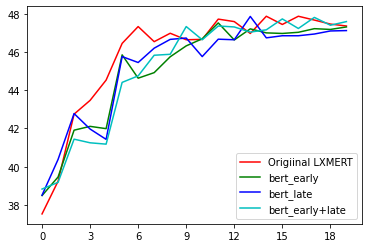

In [42]:
from matplotlib.ticker import MaxNLocator

plt.plot(x, val_base, color='r', label="Origiinal LXMERT")

plt.plot(x, val_bert_early, color='g', label="bert_early")

plt.plot(x, val_bert_late, color='b', label="bert_late")

plt.plot(x, val_bert_both, color='c', label="bert_early+late")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()

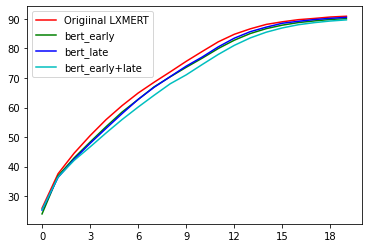

In [45]:
plt.plot(x, tr_base, color='r',label="Origiinal LXMERT")
plt.plot(x, tr_bert_early, color='g', label="bert_early")
plt.plot(x, tr_bert_late, color='b', label="bert_late")
plt.plot(x, tr_bert_both, color='c', label="bert_early+late")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()

# Error Analysis

In [50]:
import json
val_data = json.load(open('data/vqa/valid.json'))

In [141]:
lab2ans = {0:"binary", 1:"number", 2:"unanswerable", 3:"other", 4:"color"}

In [51]:
print(val_data[0])

{'img_id': 'VizWiz_val_00000000.jpg', 'question_id': 'VizWiz_val_00000000.jpg', 'sent': 'Ok. There is another picture I hope it is a better one.', 'label': {'unanswerable': 1.0, 'cannot repair this computer automatically': 0.3, 'blank screen': 0.3}, 'question_type': 'unanswerable'}


In [53]:
ans2lab = json.load(open("data/vqa/trainval_ans2label.json"))
questype2lab = json.load(open("data/vqa/trainval_questype2labels.json"))

In [54]:
print(questype2lab.keys())

dict_keys(['binary', 'unanswerable', 'number', 'color', 'other'])


In [72]:
ques2lab = {}
for key in ques2lab.keys():
  ques2lab[key] = set(questype2lab[key])

In [74]:
print(questype2lab.keys())

dict_keys(['binary', 'unanswerable', 'number', 'color', 'other'])


In [94]:
del val_data[1384]

In [96]:
del val_data[2806]

In [127]:
val_types = list(map(lambda x: x['question_type'], val_data))

In [173]:
def get_types(pred_path):
  res = json.load(open(pred_path))
  res_types = []
  for i in range(len(res)):
    lab = ans2lab[res[i]['answer']]
    for key in questype2lab.keys():
      if lab in questype2lab[key]:
        res_types.append(key)
  print(len(res_types), len(res))
  return res_types

In [183]:
from collections import defaultdict
def compare_mismatch(pred_types):
  mismatch_dict = defaultdict(lambda: 0)
  for i in range(len(pred_types)):
    if pred_types[i] != val_types[i]:
      mismatch_dict[(pred_types[i], val_types[i])] += 1
  for k, v in mismatch_dict.items():
    print(f"predicted_type: {k[0]:15s}, actual_type:{k[1]:15s}, num_occur: {v:5d}, ratio: {v / 4317.0:.3f}")
  return mismatch_dict

In [177]:
type2index = {"binary": 0, "number": 1, "unanswerable": 2, "other": 3, "color": 4}

In [175]:
import numpy as np
import seaborn as sns
def get_heatmap(pred_types):
  tag_offset = np.zeros((5, 5))
  for i in range(len(pred_types)):
    if pred_types[i] != val_types[i]:
      tag_offset[type2index[pred_types[i]]][type2index[val_types[i]]] += 1
  print(np.sum(tag_offset))
  return tag_offset, np.sum(tag_offset)


In [181]:
def eval_answerability(pred_types):
  true_positive, false_positive, true_negative, false_negative = 0, 0, 0, 0
  for i in range(len(pred_types)):
    if pred_types[i] == "unanswerable":
      if val_types[i] == "unanswerable":
        true_positive += 1
      else:
        false_positive += 1
    if val_types[i] == "unanswerable":
      if pred_types[i] != "unanswerable":
        false_negative += 1
    if val_types[i] != "unanswerable" and pred_types[i] != "unanswerable":
      true_negative += 1

  precision = float(true_positive) / (true_positive + false_positive)
  recall = float(true_positive) / (true_positive + false_negative)
  f1 = 2 * precision * recall / (precision + recall)
  print(f"precision: {precision:5.3f}, recall: {recall:5.3f}, f1: {f1:5.3f}")
  return precision, recall, f1

In [178]:
baseline_path = "/content/gdrive/MyDrive/lxmert/snap/vqa/baseline_out/valid_predict.json"
bert_early_path = "/content/gdrive/MyDrive/lxmert/snap/vqa/bert_early_fuse_out/valid_predict.json"
bert_late_path = "/content/gdrive/MyDrive/lxmert/snap/vqa/bert_last_fuse_a_0_5_out/valid_predict.json"
bert_el_path = "/content/gdrive/MyDrive/lxmert/snap/vqa/bert_e_and_l_fuse_out/valid_predict.json"

Baseline

In [184]:
baseline_types = get_types(baseline_path)
baseline_offset_matrix, baseline_total_offset = get_heatmap(baseline_types)
baseline_mis_dict = compare_mismatch(baseline_types)
baseline_prec, baseline_rec, baseline_f1 = eval_answerability(baseline_types)

4317 4317
1324.0
predicted_type: unanswerable   , actual_type:other          , num_occur:   766, ratio: 0.177
predicted_type: other          , actual_type:unanswerable   , num_occur:   138, ratio: 0.032
predicted_type: binary         , actual_type:unanswerable   , num_occur:    80, ratio: 0.019
predicted_type: unanswerable   , actual_type:number         , num_occur:    28, ratio: 0.006
predicted_type: binary         , actual_type:other          , num_occur:    31, ratio: 0.007
predicted_type: unanswerable   , actual_type:binary         , num_occur:    49, ratio: 0.011
predicted_type: other          , actual_type:color          , num_occur:    55, ratio: 0.013
predicted_type: color          , actual_type:other          , num_occur:    90, ratio: 0.021
predicted_type: other          , actual_type:binary         , num_occur:     1, ratio: 0.000
predicted_type: color          , actual_type:unanswerable   , num_occur:    31, ratio: 0.007
predicted_type: number         , actual_type:unanswer

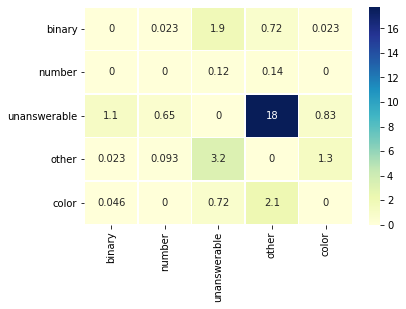

In [200]:
x = ["binary", "number", "unanswerable", "other", "color"]
y = ["binary", "number", "unanswerable", "other", "color"]
ax = sns.heatmap(baseline_offset_matrix / 43.17, linewidths=.5, annot=True, xticklabels=x, yticklabels=y, cmap="YlGnBu")

BERT-LATE

In [185]:
bert_late = get_types(bert_late_path)
bert_late_offset_matrix, bert_late_total_offset = get_heatmap(bert_late)
bert_late_mis_dict = compare_mismatch(bert_late)
bert_late_prec, bert_late_rec, bert_late_f1 = eval_answerability(bert_late)

4317 4317
1395.0
predicted_type: unanswerable   , actual_type:other          , num_occur:   868, ratio: 0.201
predicted_type: color          , actual_type:unanswerable   , num_occur:    32, ratio: 0.007
predicted_type: unanswerable   , actual_type:number         , num_occur:    30, ratio: 0.007
predicted_type: binary         , actual_type:unanswerable   , num_occur:    76, ratio: 0.018
predicted_type: unanswerable   , actual_type:binary         , num_occur:    47, ratio: 0.011
predicted_type: other          , actual_type:unanswerable   , num_occur:   106, ratio: 0.025
predicted_type: binary         , actual_type:other          , num_occur:    26, ratio: 0.006
predicted_type: binary         , actual_type:color          , num_occur:     3, ratio: 0.001
predicted_type: color          , actual_type:other          , num_occur:    84, ratio: 0.019
predicted_type: unanswerable   , actual_type:color          , num_occur:    44, ratio: 0.010
predicted_type: number         , actual_type:unanswer

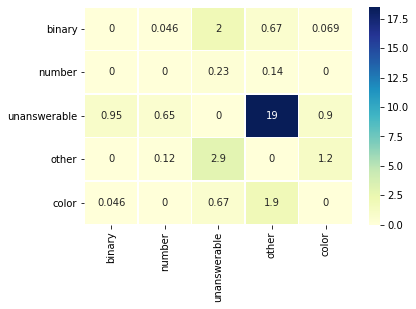

In [199]:
ax = sns.heatmap(bert_late_offset_matrix / 43.17, linewidths=.5, annot=True, xticklabels=x, yticklabels=y, cmap="YlGnBu")

BERT EARLY

In [187]:
bert_late = get_types(bert_early_path)
bert_late_offset_matrix, bert_late_total_offset = get_heatmap(bert_late)
bert_late_mis_dict = compare_mismatch(bert_late)
bert_late_prec, bert_late_rec, bert_late_f1 = eval_answerability(bert_late)

4317 4317
1442.0
predicted_type: unanswerable   , actual_type:other          , num_occur:   913, ratio: 0.211
predicted_type: other          , actual_type:unanswerable   , num_occur:   117, ratio: 0.027
predicted_type: color          , actual_type:unanswerable   , num_occur:    31, ratio: 0.007
predicted_type: binary         , actual_type:unanswerable   , num_occur:    82, ratio: 0.019
predicted_type: unanswerable   , actual_type:number         , num_occur:    37, ratio: 0.009
predicted_type: binary         , actual_type:other          , num_occur:    22, ratio: 0.005
predicted_type: unanswerable   , actual_type:binary         , num_occur:    44, ratio: 0.010
predicted_type: other          , actual_type:color          , num_occur:    52, ratio: 0.012
predicted_type: color          , actual_type:other          , num_occur:    92, ratio: 0.021
predicted_type: unanswerable   , actual_type:color          , num_occur:    35, ratio: 0.008
predicted_type: other          , actual_type:binary  

BERT Early+Late

In [188]:
bert_late = get_types(bert_el_path)
bert_late_offset_matrix, bert_late_total_offset = get_heatmap(bert_late)
bert_late_mis_dict = compare_mismatch(bert_late)
bert_late_prec, bert_late_rec, bert_late_f1 = eval_answerability(bert_late)

4317 4317
1336.0
predicted_type: unanswerable   , actual_type:other          , num_occur:   799, ratio: 0.185
predicted_type: other          , actual_type:unanswerable   , num_occur:   125, ratio: 0.029
predicted_type: color          , actual_type:unanswerable   , num_occur:    29, ratio: 0.007
predicted_type: binary         , actual_type:unanswerable   , num_occur:    85, ratio: 0.020
predicted_type: unanswerable   , actual_type:number         , num_occur:    28, ratio: 0.006
predicted_type: binary         , actual_type:other          , num_occur:    29, ratio: 0.007
predicted_type: unanswerable   , actual_type:binary         , num_occur:    41, ratio: 0.009
predicted_type: color          , actual_type:other          , num_occur:    83, ratio: 0.019
predicted_type: binary         , actual_type:color          , num_occur:     3, ratio: 0.001
predicted_type: unanswerable   , actual_type:color          , num_occur:    39, ratio: 0.009
predicted_type: number         , actual_type:unanswer

Joint

In [186]:
joint_path = "/content/gdrive/MyDrive/lxmert/snap/vqa/lxmert_joint_out/valid_predict.json"
joint_type = get_types(joint_path)
joint_om, joint_to = get_heatmap(joint_type)
joint_dict = compare_mismatch(joint_type)
joint_prec, joint_rec, joint_f1 = eval_answerability(joint_type)

4317 4317
1396.0
predicted_type: unanswerable   , actual_type:other          , num_occur:   880, ratio: 0.204
predicted_type: binary         , actual_type:unanswerable   , num_occur:    84, ratio: 0.019
predicted_type: other          , actual_type:unanswerable   , num_occur:   101, ratio: 0.023
predicted_type: binary         , actual_type:other          , num_occur:    34, ratio: 0.008
predicted_type: unanswerable   , actual_type:binary         , num_occur:    40, ratio: 0.009
predicted_type: number         , actual_type:unanswerable   , num_occur:     9, ratio: 0.002
predicted_type: other          , actual_type:color          , num_occur:    56, ratio: 0.013
predicted_type: color          , actual_type:other          , num_occur:    83, ratio: 0.019
predicted_type: unanswerable   , actual_type:color          , num_occur:    38, ratio: 0.009
predicted_type: unanswerable   , actual_type:number         , num_occur:    31, ratio: 0.007
predicted_type: number         , actual_type:other   

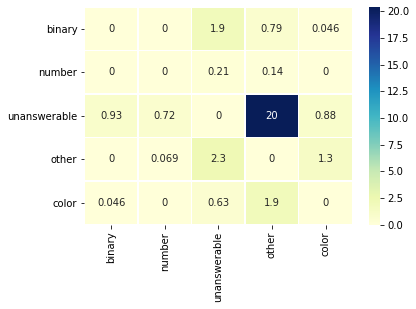

In [198]:
ax = sns.heatmap(joint_om / 43.17, linewidths=.5, annot=True, xticklabels=x, yticklabels=y, cmap="YlGnBu")